# OWF site location optimisation

* Optimise according to physical restraints (depth), and according to simulated performance across a range of sample days (energy potential of the site).

In [2]:
import tensorflow as tf
import os
from os.path import exists
from tensorflow.python.keras.models import load_model
from platypus import NSGAII, NSGAIII, Problem, Real, nondominated
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import path
from shapely.geometry import Polygon
from descartes import PolygonPatch
import pylab as pl
from shapely import affinity


In [3]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [4]:
class OWF(Problem):
    def __init__(self, lat_limits, lon_limits, data, map_polygon):
        """Locate optimal location (lat and long) in an area, to maximise
        Nvars: 11 (rotation of shape, lat/long center coordinates, 4 sets of lat/long offsets from center to define corners)
        Nobjs: 3 (depth, wind potential of site, area of site)
        Nconstraints: 1 (intersection of map polygon and solution polygon)
        """
        super(OWF, self).__init__(11, 3, 1)

        self.lat_limits = lat_limits
        self.lon_limits = lon_limits

        lat_range = lat_limits[1] - lat_limits[0]
        lon_range = lon_limits[1] - lon_limits[0]

        # only predict locations within the site boundaries
        # allow predictions to be Real numbers (i.e. floats)
        self.types = [
            # polygon is rotated by rotation angle
            Real(0, 360),

            # center of site
            Real(self.lon_limits[0], self.lon_limits[1]),  # center lat
            Real(self.lat_limits[0], self.lat_limits[1]),  # center lon

            # corners are offset from center coordinates

            Real(-lon_range, 0),    # q1 lon
            Real(0, lat_range),     # q1 lat
            
            Real(0, lon_range),     # q2 lon
            Real(0, lat_range),     # q2 lat

            Real(0, lon_range),     # q3 lon
            Real(-lat_range, 0),    # q3 lat

            Real(-lon_range, 0),    # q4 lon
            Real(-lat_range, 0),    # q4 lat
        ]

        self.directions = [
            Problem.MAXIMIZE,  # maximise depth (all depths are negative)
            Problem.MAXIMIZE,  # maximise wind potential
            Problem.MINIMIZE,  # minimise area used
        ]

        self.constraints = [
           ">98",  # constrain valid shapes to have >98% intersection with site boundary
        ]

        self.data = data

        self.map_polygon = map_polygon

    def evaluate(self, solution):
        """Evaluate variables of solution to determine fitness.

        Solution variables contain the following:
            rotation: rotation of the polygon about the center point.

            center_lat: latitude of the center point.
            center_lon: longitude of the center point.

            q1_lat: latitude of the first point of the quadrilateral.
            q1_lon: longitude of the first point of the quadrilateral.
            q2_lat: latitude of the second point of the quadrilateral.
            q2_lon: longitude of the second point of the quadrilateral.
            q3_lat: latitude of the third point of the quadrilateral.
            q3_lon: longitude of the third point of the quadrilateral.
            q4_lat: latitude of the fourth point of the quadrilateral.
            q4_lon: longitude of the fourth point of the quadrilateral.
        """

        x = solution.variables[:]

        # read solution into variables
        rotation = x[0]
        center = x[1:3]
        q1, q2, q3, q4 = x[3:5], x[5:7], x[7:9], x[9:11]
        
        # calculate corner coordinates from center and q offset
        q1_coord = [center[0] + q1[0], center[1] + q1[1]]
        q2_coord = [center[0] + q2[0], center[1] + q2[1]]
        q3_coord = [center[0] + q3[0], center[1] + q3[1]]
        q4_coord = [center[0] + q4[0], center[1] + q4[1]]

        # rotation corner coordinates by rotation angle
        points = np.array([q1_coord, q2_coord, q3_coord, q4_coord])

        # define polygon as path
        polygon = path.Path(points)
        # get data within polygon
        data_polygon = self.data[
            polygon.contains_points(self.data[["Lon", "Lat"]].values)
        ]


        shapely_polygon = Polygon(points).buffer(0)

        # rotate polygon by rotation angle about center coordinate
        shapely_polygon = affinity.rotate(shapely_polygon, rotation, origin=center)

        # calculate intersection area between map polygon and solution polygon
        intersection = self.map_polygon.intersection(shapely_polygon).area
        intersection = intersection / shapely_polygon.area * 100.0
        # print('Coverage: ', intersection / shapely_polygon.area*100, '%')

        # dataframe is empty, because no data at that location (out of bounds / too small), set depth and wind potential to -inf
        if data_polygon.empty:
            area = np.inf
            depth = -np.inf
            wind_potential = -np.inf

        else:
            area = shapely_polygon.area * 100

            # get average depth from bathymetric data polygon
            depth = data_polygon["Depth"].mean()

            # get average wind potential from wind data polygon
            wind_potential = data_polygon["Chi"].mean()

        # print(f'Depth: {depth:.2f}, Wind Potential: {wind_potential:.2f}, Area: {area:.2f}, Intersection: {intersection:.2f}')

        solution.objectives[:] = [
            depth,
            wind_potential,
            area,
        ]
        
        solution.constraints[:] = [intersection]


In [5]:
data = pd.read_csv("data/UK east coast.csv")

data_lat_range = (min(data["Lat"]), max(data["Lat"]))
data_lon_range = (min(data["Lon"]), max(data["Lon"]))

print(f"Latitude range: {data_lat_range}, Longitude range: {data_lon_range}")


Latitude range: (53.486257927, 54.8083537), Longitude range: (-0.5269085, 2.5571098)


In [6]:
# read map polygon coords and create polygon
polygon_df = pd.read_csv("data/UK east coast edge points alpha 17.5.csv")
polygon_np = polygon_df.to_numpy()

# swap columns (lon, lat) to (lat, lon)
polygon_np = polygon_np[:, [1, 0]]

map_polygon = Polygon(polygon_np)


In [7]:
# load the problem
problem = OWF(
    lat_limits=data_lat_range,
    lon_limits=data_lon_range,
    data=data,
    map_polygon=map_polygon,
)


In [8]:
# run the optimisation
algorithm = NSGAII(problem)
algorithm.run(10000)


In [9]:
# get feasible and nondominated solutions
feasible_solutions = [s for s in algorithm.result if s.feasible]
nondominated_solutions = nondominated(feasible_solutions)
Y = np.array([s.objectives for s in nondominated_solutions])


In [10]:
# convert results to pandas dataframe
results = pd.DataFrame(
    columns=[
        "rotation",
        "center_lon",
        "center_lat",
        "q1_lon",
        "q1_lat",
        "q2_lon",
        "q2_lat",
        "q3_lon",
        "q3_lat",
        "q4_lon",
        "q4_lat",
        "Depth",
        "Wind Potential",
        "Area",
        "Intersection",
    ]
)

# read nondominated solutions into dataframe
for i, solution in enumerate(nondominated_solutions):
    results.loc[i] = [*solution.variables[:], *solution.objectives]

print(results)


      rotation  center_lon  center_lat    q1_lon    q1_lat    q2_lon  \
0   171.883588   -0.171906   54.110538 -0.193713  0.005694  0.030093   
1   131.613490    0.693632   53.977838 -0.452429  0.009936  0.187826   
2   170.389786    2.196078   53.532576 -0.007007  0.003319  0.019105   
3   131.583024    2.217992   53.586641 -0.000544  0.004216  0.002438   
4   241.070044    1.856432   54.521767 -0.019944  0.826636  2.404540   
..         ...         ...         ...       ...       ...       ...   
95  126.596016    1.568463   53.487975 -0.007009  0.036102  0.874110   
96  122.553260    0.787977   53.487665 -0.019347  0.004477  1.775027   
97  241.070044    1.856432   54.521767 -0.019944  0.040781  2.404540   
98  146.433467   -0.180912   54.110454 -0.102898  0.002262  0.057187   
99  155.963705   -0.103628   54.112170 -0.219214  0.003776  0.017512   

      q2_lat    q3_lon    q3_lat    q4_lon    q4_lat      Depth  \
0   0.030748  0.189104 -1.294770 -0.154389 -0.458191  -1.050000   
1

In [11]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2])
ax.set_xlabel('Depth')
ax.set_ylabel('Wind Potential')
ax.set_zlabel('Area')
plt.show()


In [ ]:

def plotSolution(x, fig, ax):
    x = results.loc[idx]
    x = x.reset_index(drop=True)

    x = x.to_numpy()

    # set title
    ax.set_title(f"Depth: {x[11]:.2f}m, Wind Potential: {x[12]:.2f}m/s, Area: {x[13]:.2f}%, Intersection: {x[14]:.2f}%")

    # read solution into variables
    rotation = x[0]
    center = x[1:3]
    q1, q2, q3, q4 = x[3:5], x[5:7], x[7:9], x[9:11]
    
    # calculate corner coordinates from center and q offset
    # REVERSE XY from LAT LON to LON LAT
    q1_coord = [center[0] + q1[0], center[1] + q1[1]]
    q2_coord = [center[0] + q2[0], center[1] + q2[1]]
    q3_coord = [center[0] + q3[0], center[1] + q3[1]]
    q4_coord = [center[0] + q4[0], center[1] + q4[1]]

    # rotation corner coordinates by rotation angle
    points = np.array([q1_coord, q2_coord, q3_coord, q4_coord])

    polygon = Polygon(points)
    # rotate polygon by rotation angle about center coordinate
    polygon = affinity.rotate(polygon, rotation, origin=center)

    center_point = ax.scatter(center[0], center[1], c="r", marker="*")

    patch = PolygonPatch(polygon, fc="#999999", ec="#000000", fill=False)
    ax.add_patch(patch)

    # save figure
    fig.savefig(f"results/{idx}.png")

    # reset patches for next iteration
    patch.remove()
    center_point.remove()

c:\Users\zacha\miniconda3\envs\py10\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\Users\zacha\miniconda3\envs\py10\lib\site-packages\shapely\affinity.py:109: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if origin == 'center':
c:\Users\zacha\miniconda3\envs\py10\lib\site-packages\shapely\affinity.py:113: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif origin == 'centroid':


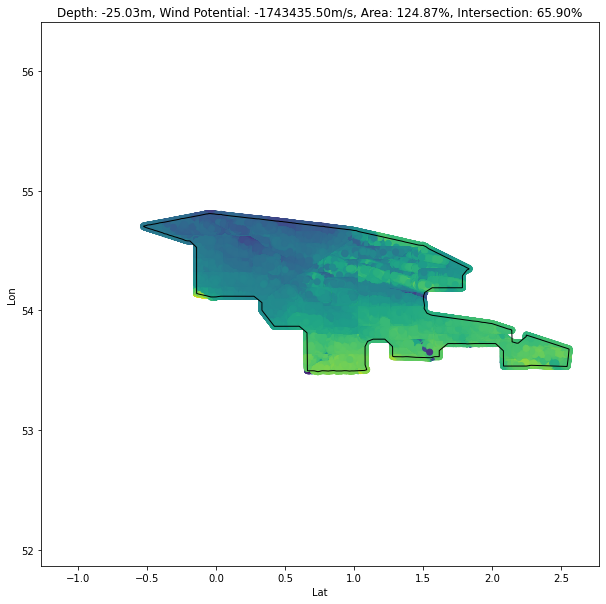

In [22]:
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# load depth scatter into plot and reuse
map = ax.scatter(data["Lon"], data["Lat"], c=data["Depth"], cmap="viridis")

ax.set_xlabel("Lat")
ax.set_ylabel("Lon")

map_patch = PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False)
ax.add_patch(map_patch)

for idx, x in results.iterrows():
    plotSolution(x, fig, ax)
